In [25]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Bayesian Calibration

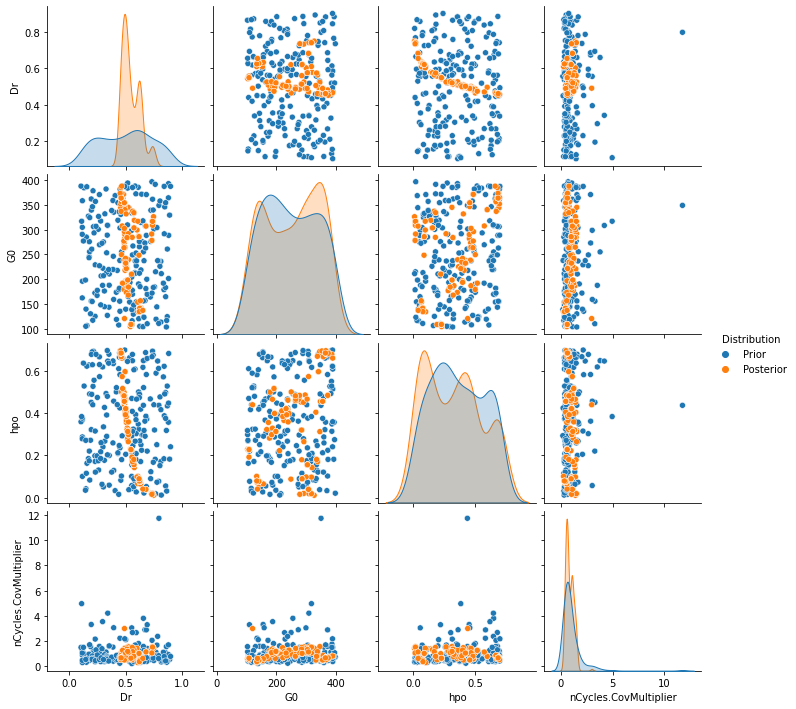

<Figure size 432x288 with 0 Axes>

In [20]:
import pandas as pd

data1 = pd.read_csv(r"C:\Users\adith\Documents\Ottawa200Samples-BC\dakotaTab.out", delimiter = '\t', usecols = [2,3,4,5])
data1['Distribution'] = 'Posterior'
data2 = pd.read_csv(r"C:\Users\adith\Documents\Ottawa200Samples-BC\dakotaTabPrior.out", delimiter = '\t', usecols = [2,3,4,5])
data2['Distribution'] = 'Prior'
# print(data1)
# print(data2)


#combine = pd.merge(data1, data2, left_index=True, right_index=True, how='outer')
combine = data2.append([data1], ignore_index=True)
# print(combine)

sb.pairplot(combine, hue = "Distribution")
plt.show()
plt.savefig('Pairplot200Samples.png')

In [47]:
def readFiles(fname, maxgamma):
    f = fname;
    
    # read in columns corresponding to each value
    shearstrain = np.genfromtxt(f, delimiter="\t", skip_header=1, usecols = (0));
    # indices = np.abs(shearstrain) <= maxgamma
    index = 0;
    for x in shearstrain:
        index += 1;
        if abs(x) > maxgamma:
            break;
    
    shearstress = np.genfromtxt(f, delimiter= "\t", skip_header=1, usecols = (1));
    effectivestress = np.genfromtxt(f, delimiter = "\t", skip_header=1, usecols = (3));
    axialstrain = np.genfromtxt(f, delimiter = "\t", skip_header=1, usecols = (2));
    
    return shearstrain[:index], shearstress[:index], effectivestress[:index], axialstrain[:index]


def StressStrain(pdfname, shearstrain, shearstress, effectivestress, axialstrain):
    
    pdfn = pdfname;
    
    
    fig = plt.figure(figsize=(14, 4))
    ax = plt.axes()
    line, = plt.plot([],[],lw=2)

    plt.subplot(1, 5, 1)

    # Shear stress (kPA) vs. Shear strain (%)
    plt.plot(shearstrain, shearstress, 'black');
    plt.grid(which = 'major');
    plt.grid(which = 'minor', linewidth = '0.5');
    plt.xlabel(r'$\gamma$ (%)');
    plt.ylabel(r'$\tau$ (kPa)');
    

    plt.subplot(1, 5, 2)

    # Shear stress (kPA) vs. Effective Vertical Stress (kPA)
    plt.plot(effectivestress, shearstress, 'blue');
    plt.grid(which = 'major');
    plt.grid(which = 'minor', linewidth = '0.5');
    plt.xlabel(r'$\sigma_v$ (%)');
    plt.ylabel(r'$\tau$ kPa)');
    

    plt.subplot(1, 5, 3)

    # Effective Vertical Stress (kPA) vs. Shear Strain (%)
    plt.plot(shearstrain, effectivestress, 'green'); 
    plt.title(pdfn); # title of the test
    plt.grid(which = 'major');
    plt.grid(which = 'minor', linewidth = '0.5');
    plt.xlabel(r'$\gamma$ (%)');
    plt.ylabel(r'$\sigma_v$ (kPa)');


    plt.subplot(1, 5, 4)

    # Axial Strain (%) vs. Shear Strain (%)
    plt.plot(shearstrain, axialstrain, 'red');
    plt.grid(which = 'major');
    plt.grid(which = 'minor', linewidth = '0.5');
    plt.xlabel(r'$\gamma$ (%)');
    plt.ylabel(r'Axial Strain (kPa)');
    
    plt.subplot(1, 5, 5)

    # Ru vs. Shear Strain (%)
    ru = 1 - effectivestress/effectivestress[0]
    plt.plot(shearstrain, ru, 'black', label = r"$1 - \frac{\sigma_v}{\sigma_{vo}}$");
    plt.grid(which = 'major');
    plt.grid(which = 'minor', linewidth = '0.5');
    plt.xlabel(r'$\gamma$ (%)');
    plt.ylabel(r'Ru');
    plt.legend();
    
    plt.tight_layout();
    
    def init():
        line.set_data([],[])
        return line,
    
    def animate(i):
        x = shearstrain 
        y = shearstress
        line.set_data(x,y)  # update the data.
        return line,

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames = 200, interval=20, blit=True, save_count=50)
    
    plt.show(ani);

    plot = plt.savefig(pdfn, format = 'pdf')
    
    plt.close()

    return pdfn

def cycles(shearstress, level):
    maxtau = np.max(shearstress)
    shearstress -= level;
    prev = shearstress[0];
    count = 0;
    for x in shearstress[1:]:
        if prev*x < 0:
            count+=1;
        prev = x;
        
    return count/2, maxtau

def WriteCycles(fname, csr, ncycles):
    expdata = open(fname, 'a');
    expdata.write('{:6.3f} {:6.2f}\n'.format(csr, ncycles))
    expdata.close();
    
    return 

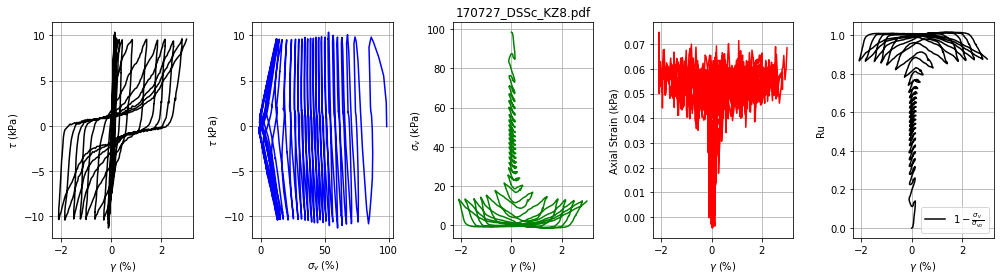

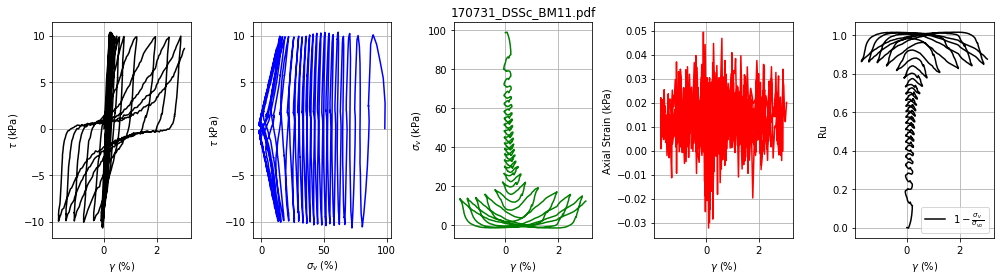

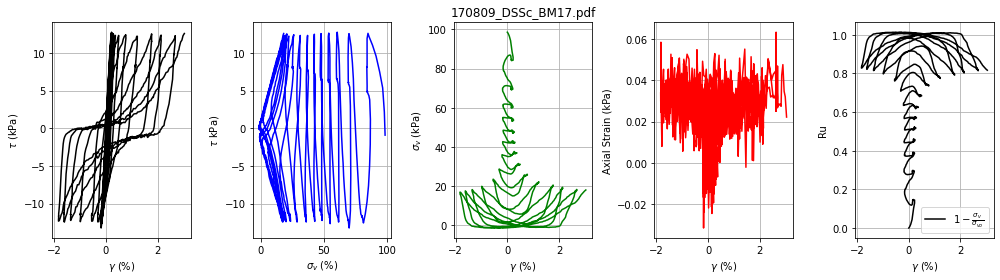

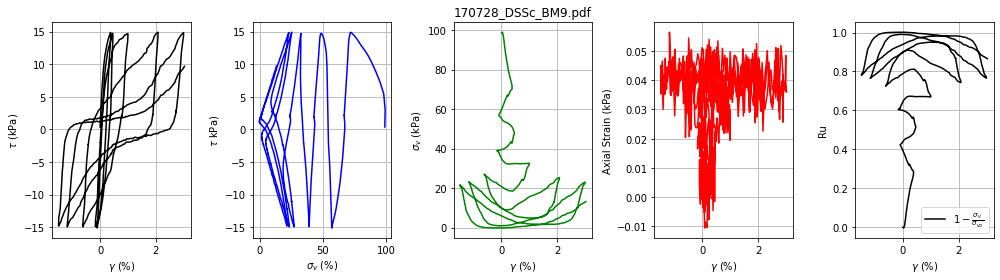

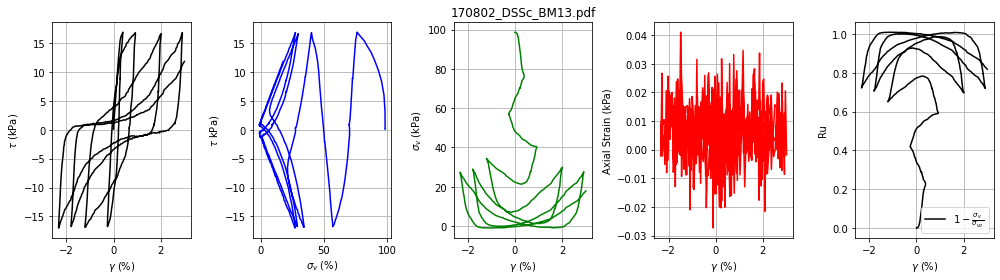

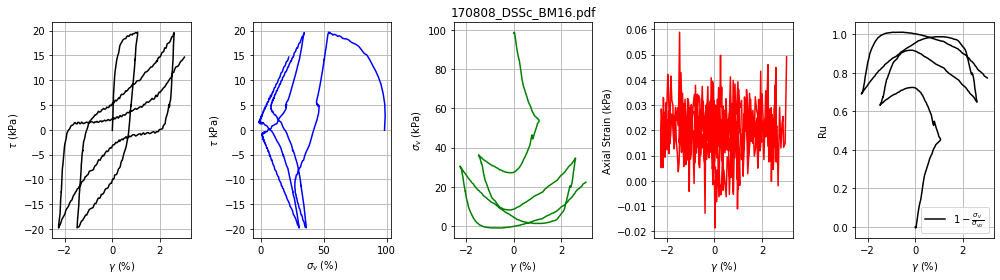

In [48]:
files = ["170727_DSSc_KZ8.txt", "170731_DSSc_BM11.txt", "170809_DSSc_BM17.txt", "170728_DSSc_BM9.txt",  "170802_DSSc_BM13.txt", "170808_DSSc_BM16.txt"]

from PyPDF2 import PdfFileReader, PdfFileMerger # for creating a combined pdf of all stress strain plots

results = PdfFileMerger()
expdata = 'Ottawa_F65_ExpData.txt';
open(expdata, 'w').close();


for x in files:
    shearstrain, shearstress, effectivestress, axialstrain = readFiles(x, 3);
    pdfname = StressStrain(x.replace(".txt", ".pdf"), shearstrain, shearstress, effectivestress, axialstrain);
    cyclescount, maxtau = cycles(shearstress, -5)
    csr = maxtau/effectivestress[0];
    WriteCycles(expdata, csr, cyclescount);
    # print(cyclescount)
    pdf_file = PdfFileReader(pdfname)
    results.append(pdfname)

# createCombinedPlots(expDataFile=expdata, simDataFile='nCyclesResultD.dat', cols=1)
    
with open("Ottawa-F65-StressStrainPlots.pdf", "wb") as output_stream:
    results.write(output_stream)
        